# Source code for "Rating Analyst Degrees of Freedom" - Vijay Raghavan, UMKC Law Rev. 2018 (forthcoming)

## Code adapted from: https://turi.com/learn/gallery/notebooks/predict-loan-default.html

Importing data and relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

loans = pd.read_csv('loan_data.csv')

Eliminating null entries, creating separate data frames for active and inactive loans, and series for whether loan succeeded or failed

In [2]:
loans = loans.fillna(0)
inactive_loans = loans[loans['inactive_loans'] == 1]
active_loans = loans[loans['inactive_loans'] == 0]

y = inactive_loans['bad_loans'].astype(int)

Limiting features to train model on.  Separating numerical and categorical variables

In [3]:
num_features_limited = ['sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'dti',                       # debt to income ratio
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

cat_features_limited = ['grade',                     # grade of the loan (categorical)
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'purpose',                   # the purpose of the loan
            ]

Defining class to transform categorical variables

In [4]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


Creating new data sets for inactive and active loans with modified categorial variables 

In [7]:
inactive_loans_num = inactive_loans[num_features_limited]
inactive_loans_cat = inactive_loans[cat_features_limited]
inactive_loans_cat = MultiColumnLabelEncoder(columns = cat_features_limited).fit_transform(inactive_loans_cat)
inactive_loans_final = pd.concat([inactive_loans_num,inactive_loans_cat],axis=1)

X = inactive_loans_final.copy()

X = X.reindex_axis(sorted(X.columns), axis=1)
X = X.fillna(0)

active_loans_num = active_loans[num_features_limited]
active_loans_cat = active_loans[cat_features_limited]
active_loans_cat = MultiColumnLabelEncoder(columns = cat_features_limited).transform(active_loans_cat)
active_loans_final = pd.concat([active_loans_num,active_loans_cat],axis=1)

X_active = active_loans_final.copy()

X_active = X_active.reindex_axis(sorted(X_active.columns), axis=1)
X_active = X_active.fillna(0)

Function to return stats for models

In [6]:
def model_stats(model, x_test, y_test, active):
    accuracy = "%.12f" % (accuracy_score(y_test, model1.predict(x_test).astype(int)))
    precision = "%.12f" % (precision_score(y_test, model1.predict(x_test).astype(int)))
    recall = "%.12f" % (recall_score(y_test, model1.predict(x_test).astype(int)))
    defaults = "%d" % (model1.predict(X_active).sum())
    
    return [[accuracy, precision, recall, defaults]]

Training, testing, and forecasting for logistic models with different training/test ratios

In [8]:
data = np.array([np.arange(9)]*4).T
splits = []

for i in range(9):
    splits.append("%d/%d" % ((i+1)*10, 100-(i+1)*10))

model1_summary = pd.DataFrame(data, index=splits, columns=["Accuracy","Precision","Recall","Defaults"])

for i in range(9):
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=float(i+1)/float(10), random_state=5)
    model1 = LogisticRegression(class_weight='balanced')
    model1.fit(x_train,y_train)
    split = ["%d/%d" % ((i+1)*10, 100-(i+1)*10)]
    stats = model_stats(model1, x_test, y_test, X_active)[0]
    model1_summary["Accuracy"][split] = stats[0]
    model1_summary["Precision"][split] = stats[1]
    model1_summary["Recall"][split] = stats[2]
    model1_summary["Defaults"][split] = stats[3]

In [9]:
model1_summary.sort("Defaults")

,Accuracy,Precision,Recall,Defaults
40/60,0.663725956637,0.305885315490,0.609708877097,136721
10/90,0.666397817793,0.307349342121,0.606570704414,136737
50/50,0.661588150855,0.303113357030,0.612760799931,137304
30/70,0.662802213807,0.305335333190,0.614943591640,137595
20/80,0.664967477520,0.306567762196,0.609735085074,137700
60/40,0.660440837632,0.303023850085,0.615151842646,137846
70/30,0.657205774407,0.302142606252,0.616542431193,139152
90/10,0.656797977326,0.298275136727,0.619213973799,139270
80/20,0.660141913384,0.304697418536,0.620422231797,139408


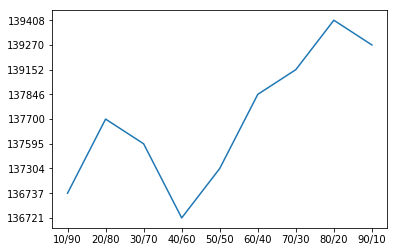

In [14]:
fig, ax = plt.subplots()
# set x labels and y labels
ax.plot(model1_summary.index.tolist(),model1_summary["Defaults"].tolist())

In [15]:
# Creating new DataFrame for models populated with Logistic Regression with 40/60 split
data = np.array([np.arange(3)]*4).T
models_summary = pd.DataFrame(data, index=["Logistic Regression", "Decision Tree", "Nearest Neighbors"], 
                              columns=["Accuracy","Precision","Recall","Predicted Defaults"])

models_summary["Accuracy"]["Logistic Regression"] = model1_summary["Accuracy"]["40/60"]
models_summary["Precision"]["Logistic Regression"] = model1_summary["Precision"]["40/60"]
models_summary["Recall"]["Logistic Regression"] = model1_summary["Recall"]["40/60"]
models_summary["Predicted Defaults"]["Logistic Regression"] = model1_summary["Defaults"]["40/60"]

# Decision Tree classifier
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=5)
model2 = DecisionTreeClassifier(max_depth=4, max_features='sqrt', class_weight='balanced')
model2.fit(x_train,y_train) 
stats = model_stats(model2, x_test, y_test, X_active)[0] 
models_summary["Accuracy"]["Decision Tree"] = stats[0]
models_summary["Precision"]["Decision Tree"] = stats[1]
models_summary["Recall"]["Decision Tree"] = stats[2]
models_summary["Predicted Defaults"]["Decision Tree"] = stats[3]

In [18]:
# Nearest Neighbors
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=5)
model1 = KNeighborsClassifier(n_neighbors=1)
model1.fit(x_train,y_train)
stats = model_stats(model1, x_test, y_test, X_active)[0] 
models_summary["Accuracy"]["Nearest Neighbors"] = stats[0]
models_summary["Precision"]["Nearest Neighbors"] = stats[1]
models_summary["Recall"]["Nearest Neighbors"] = stats[2]
models_summary["Predicted Defaults"]["Nearest Neighbors"] = stats[3]

In [19]:
models_summary

,Accuracy,Precision,Recall,Predicted Defaults
Logistic Regression,0.663725956637,0.305885315490,0.609708877097,136721
Decision Tree,0.660490722490,0.304140919099,0.614082891152,139270
Nearest Neighbors,0.724964317270,0.261548964576,0.247239351785,63885
